#### Setup

Resolve input/output files.

Identify rail lines as catenary based on tagging and prediction.

For GIS files
For global files

comparison between 3 types of collection

In [ ]:
# 10.2.9.20
#  cd ../../media/nvidia/Mercyhurst/wabtec/rail_classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import sys
from datetime import datetime
from shapely.geometry import Point, LineString, shape,mapping
import geopandas as gpd

In [2]:
def WriteJSON(obj,filename):
    with open(filename, 'w+') as outfile:
        try:
            obj_json = json.dumps(obj, sort_keys=True, indent=4,default=str)
            outfile.write(obj_json)
        except Exception as e:
            print(e, file=sys.stderr)
            print('File not written.')

In [3]:
def ReadJSON(filename):
    obj = []
    try: 
        with open(filename, 'r') as infile:
            obj = json.load(infile)
    except Exception as e:
        print(e, file=sys.stderr)
        print('File not found.')
        
    return obj

In [7]:
def NamesToPoint():
    rows = curr_df.index.tolist()
    points = []
    for row in rows:
        tmp = curr_df.iloc[row].Name
        space = tmp.find('_') 
        longitude = tmp[:space]
        latitude = tmp[space+1:]
        points.append((longitude,latitude))
        
    return 

In [8]:
'''
Get all points
'''
def PointsFromLine(line):
    points = []
    if line.geom_type == 'LineString':
        print('LineString')
#         g = route.geometry
        sec_points = mapping(line)["coordinates"]
#         print(len(sec_points))
        for j in sec_points:
            tmp = (j[0],j[1])
            points.append(tmp)
    elif line.geom_type == 'MultiLineString':
        print('MultiLineString')
#         g = route.geometry
        tmp = mapping(line)["coordinates"]
        for sec_points in tmp:
            for j in sec_points:
                tmp = (j[0],j[1])
                points.append(tmp)

    return points

### Start Program

In [5]:
'''
Parameters 
----------
Set for each test. 


img_folder: Root folder of image collection

results_file: JSON file for output of results and metadata

description: String for labeling/notes

sample_size: Sample size to pull from each csv, 0-1

img_size: Native resolution is 1280x1280

'''

img_folder = '../data/output_images/'
rail_folder = '../data/railways/'

img_set = '2'
sample_size = 1.0

### Load CSVs

In [10]:
'''
Loads csv only, no images.
'''

# Name of folder
names = [
    'Australia',
    'Germany',
    'NewarkLR',
    'Switzerland',
    'Amtrak',
    'BostonMTBA',
    'DenverRTD',
    'LosAngelesMR',
    'SeattleLLR',
    'Netherlands'
]

# Name of csv
abbr = [
    'AUS',
    'GRM',
    'NEW',
    'SWZ',
    'AMT',
    'BOS',
    'DEN',
    'LAA',
    'SEA',
    'NET'
]
locations = dict(zip(names,abbr))

# Collect each csv into one df adding railway name
frames = []
for key,value in locations.items():
    try:
        filename = img_folder+key+'/'+value+'.csv'
        tmp = pd.read_csv(filename,header=0)
        tmp['Railway'] = key
        
        # Take sample from each folder 
        tmp = tmp.sample(frac=sample_size).reset_index(drop=True)
        frames.append(tmp)
    except Exception as e:
        print(key, e)

points = pd.concat(frames)

points = points.dropna()
points['Catenary'] = points['Catenary'].astype(int)

points = points.drop(axis=1,labels=['Latitude','Longitude'])

rows = points.index.tolist()
# print(len(rows))
lats = []
longs = []
for row in rows[:]:
    tmp = points.iloc[row].Name
    space = tmp.find('_') 
    longitude = tmp[:space]
    latitude = tmp[space+1:]
    lats.append(float(latitude))
    longs.append(float(longitude))

    # print(len(longs))
points['Longitude'] = longs
# print(lats)
points['Latitude'] = lats

points.head()

,Name,Catenary,Railway,Longitude,Latitude
6,151.1964198_-33.868837,0,Australia,153.016653,-27.463711
9,153.0328976_-27.456906099999998,1,Australia,151.147372,-33.879178
11,153.13842830000002_-30.2993999,1,Australia,151.295017,-33.496870
12,153.03352180000002_-27.443969300000003,1,Australia,152.998212,-27.527944
18,153.0492555_-27.415488,1,Australia,145.061288,-37.866968


In [11]:
points.describe()

,Catenary,Longitude,Latitude
count,939.000000,939.000000,939.000000
mean,0.597444,75.094895,12.295750
std,0.490674,69.398306,42.332241
min,0.000000,-74.175147,-37.910223
25%,0.000000,13.207718,-33.868837
50%,1.000000,13.565530,48.894773
75%,1.000000,151.147372,52.493312
max,1.000000,153.138428,53.631273


In [12]:
points['Catenary'].value_counts()

1    561
0    378
Name: Catenary, dtype: int64

In [53]:
'''
Convert points to gdf

#zip the coordinates into a point object and convert to a GeoData Frame
'''

geometry = [Point(xy) for xy in zip(points.Longitude, points.Latitude)]
geo_df = gpd.GeoDataFrame(points, geometry=geometry)
geo_df.crs = {'init' :'epsg:4269'}

geo_df.head()

,Name,Catenary,Railway,Longitude,Latitude,geometry
0,-104.990001178335_39.7001903705681,1,DenverRTD,-104.990001,39.700190,POINT (-104.990001178335 39.7001903705681)
1,-105.199574999062_39.7256896435149,0,DenverRTD,-105.199575,39.725690,POINT (-105.199574999062 39.7256896435149)
2,-105.109354896773_39.7929196270816,1,DenverRTD,-105.109355,39.792920,POINT (-105.109354896773 39.7929196270816)
3,-105.014207299478_39.8053146697398,1,DenverRTD,-105.014207,39.805315,POINT (-105.014207299478 39.8053146697398)
4,-104.981445079363_39.695535424836,0,DenverRTD,-104.981445,39.695535,POINT (-104.981445079363 39.695535424836)


### Load railways

In [138]:
'''
Load railways
'''

rail_names = [
#     'Australia',
#     'Germany',
#     'NewarkLR',
#     'Switzerland',
#     'Amtrak',
#     'BostonMTBA',
    'DenverRTD',
#     'LosAngelesMR',
#     'SeattleLLR',
#     'Netherlands'
]

# Name of folder
names = [
#     'mbta_rapid_transit',
    'denver_RTD',
#     'sound_transit',
#     'Newark_LR',
#     'LAMR/806_Expo_Track',
#     'LAMR/804_Gold_Track',
#     'LAMR/803_Green_Track',
#     'LAMR/802_Red_Purple_Track',
#     'LAMR/801_Blue_Track',
#     'NL/shapes_voor_website',
#     'germany-railways-shape',
#     'swissrail'
]

# Name of csv
abbr = [
#     'MBTA_ARC.shp',
    'LightrailLines_Center.shp',
#     'LINKLine.shp',
#     'Passenger_Railroad_Lines_in_New_Jersey.shp',
#     '806_Track_0316.shp',
#     '804_Track_0316.shp',
#     '803_Track_0316.shp',
#     '802_805_Track_0316.shp',
#     '801_Track_0316.shp',
#     'spoor.shp',
#     'railways.shp',
#     'netw_1.shp'
]
locations = dict(zip(names,abbr))
rn = dict(zip(names,rail_names))

# Collect each csv into one df adding railway name
frames = []
for key,value in locations.items():
#     print(key,value)
    try:
        filename = rail_folder+key+'/'+value
#         print(filename)
        tmp = gpd.read_file(filename)
        tmp['Railway'] = rn[key]
#         value[:4]
        
        # Take sample from each folder 
        frames.append(tmp)
    except Exception as e:
        print(key, e)

# Add acela
# routes = gpd.read_file('../data/railways/Amtrak_Routes/Amtrak_Routes.shp')
# routes = routes.iloc[[0]]
# routes['Railway'] = 'Acela'
# frames.append(routes)

rails = pd.concat(frames,sort=False)
rails.crs = {'init' :'epsg:4269'}

# df = df.dropna()

# cols = ['LINE','ROUTE','OBJECTID','Railway','geometry']
cols = ['OBJECTID','Railway','geometry']
rails = rails[cols]

rails['Catenary'] = 0

rails.head()

,OBJECTID,Railway,geometry,Catenary
0,142,DenverRTD,(LINESTRING (-105.001090582883 39.753148821931...,0
1,143,DenverRTD,(LINESTRING (-105.137784196155 39.786794639271...,0
2,144,DenverRTD,(LINESTRING (-105.007403102142 39.806185928394...,0
3,145,DenverRTD,(LINESTRING (-104.988737522449 39.748187234728...,0
4,146,DenverRTD,(LINESTRING (-104.999945166902 39.754022112124...,0


### Join Data

In [139]:
rows_points = points.index.tolist()
pos = []
for row in rows_points[:]:
    # Get point info     
    point =  geo_df.iloc[row]['geometry']
    cat = geo_df.iloc[row]['Catenary']

    # Subselect rails   
    rail = geo_df.iloc[row]['Railway']
    tmp = rails[rails['Railway']==rail]
    rows_rails = tmp.index.tolist()
    
    i=0
    found = False
    while not found and i < len(rows_rails):
        line = rails.iloc[i]['geometry']
        if line.contains(point) and cat == 1:
#             print(geo_df.iloc[row]['Catenary'],point,i)
            obj_id = int(tmp.iloc[i]['OBJECTID'])
            pos.append(obj_id)
#             tmp.at(i,'Catenary') = cat
            found = True
        i += 1
rails.head()

,OBJECTID,Railway,geometry,Catenary
0,142,DenverRTD,(LINESTRING (-105.001090582883 39.753148821931...,0
1,143,DenverRTD,(LINESTRING (-105.137784196155 39.786794639271...,0
2,144,DenverRTD,(LINESTRING (-105.007403102142 39.806185928394...,0
3,145,DenverRTD,(LINESTRING (-104.988737522449 39.748187234728...,0
4,146,DenverRTD,(LINESTRING (-104.999945166902 39.754022112124...,0


In [140]:
plus = set(pos)

In [143]:
rows = rails.index.tolist()
for row in rows:
    tmp = rails.iloc[row]
    val = int(tmp['OBJECTID'])
    if val in plus:
        rails.set_value(row,'Catenary', 1)
rails.head()

/Users/jessedecker/miniconda3/envs/geo1/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,OBJECTID,Railway,geometry,Catenary
0,142,DenverRTD,(LINESTRING (-105.001090582883 39.753148821931...,1
1,143,DenverRTD,(LINESTRING (-105.137784196155 39.786794639271...,1
2,144,DenverRTD,(LINESTRING (-105.007403102142 39.806185928394...,1
3,145,DenverRTD,(LINESTRING (-104.988737522449 39.748187234728...,0
4,146,DenverRTD,(LINESTRING (-104.999945166902 39.754022112124...,1


In [148]:
len(rails[rails['Catenary'] == 1]['Catenary'].tolist())/len(rails['Catenary'].tolist())

0.3333333333333333

In [137]:
rails.to_file('../data/railways/test')

### Load global

In [ ]:
'''
Loads csv only, no images.
'''

# Name of folder
names = [
    'global',
]

# Name of csv
abbr = [
    'australia-oceania_main',
]
locations = dict(zip(names,abbr))

# Collect each csv into one df adding railway name
frames = []
for key,value in locations.items():
    try:
        filename = rail_folder+key+'/'+value+'.csv'
        tmp = pd.read_csv(filename,header=0)
        tmp['Railway'] = key
        
        # Take sample from each folder 
        tmp = tmp.sample(frac=sample_size).reset_index(drop=True)
        frames.append(tmp)
    except Exception as e:
        print(e)

glob_rail = pd.concat(frames)

glob_rail = glob_rail.rename(columns={'Way ID (track segment)':'Line'})
glob_rail = glob_rail.dropna()

glob_rail = glob_rail.sort_values(by=['Node ID'],ascending=[False])

glob_rail.head()

In [ ]:
'''
Get list of indexes for each 
'''

lines = glob_rail['Line'].unique()
# len(lines)

rows = glob_rail.index.tolist()
totes = {}
for line in lines[:10]:
    indices = []
    for row in rows[:50000]:
        if glob_rail.iloc[row]['Line'] == line:
            indices.append(row)
    totes[line] = indices

# for key,value in totes.items():
#     print(key, value)

In [ ]:
'''
1.
'''

#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(glob_rail.Longitude, glob_rail.Latitude)]
geo_df = gpd.GeoDataFrame(glob_rail, geometry=geometry)
geo_df.crs = {'init' :'epsg:4269'}

columns = ['Line','geometry']
geo_df = geo_df[columns]

geo_df.head()

In [ ]:
'''
2.

'''

geo_df2 = geo_df.groupby(['Line'])['geometry'].apply(lambda x:LineString(x.tolist()))
tmp = np.arange(0,len(geo_df2))
geo_df2 = gpd.GeoDataFrame(geo_df2, geometry='geometry')
geo_df2.crs = {'init' :'epsg:4269'}
geo_df2['Index'] = tmp

geo_df2.head()

In [ ]:
'''
3.
'''

geo_df2['Line'] = geo_df2.index.tolist()
geo_df2.set_index('Index',inplace=True)

geo_df2 = geo_df2[['Line','geometry']]

del geo_df2.index.name
geo_df2.head()

In [ ]:
geo_df2.to_file("../data/railways/global/AUS")

In [131]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.10'

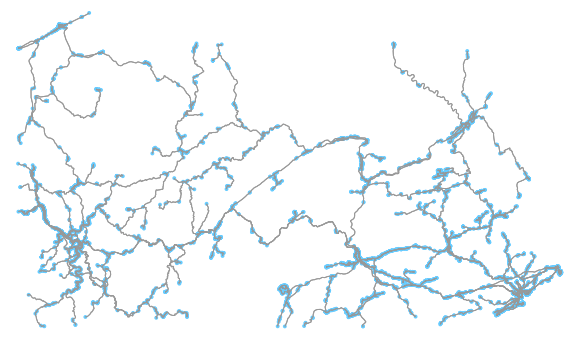

(<Figure size 991.244x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126c30c50>)

In [135]:
G = ox.graph_from_place('Pennsylvania, USA', network_type='none',infrastructure='way["railway"~"rail"]')
ox.plot_graph(G)